In [107]:
pip install pandas numpy matplotlib seaborn scikit-learn openpyxl biopython

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [111]:
import pandas as pd

genoma='C:/Users/judit/OneDrive/Escritorio/MÁSTER/TFM/data/BVBRC_genome_amr.xlsx'
df_genoma = pd.read_excel(genoma)

genes='C:/Users/judit/OneDrive/Escritorio/MÁSTER/TFM/data/BVBRC_sp_gene.xlsx'
df_genes = pd.read_excel(genes)

In [112]:
from Bio import SeqIO
genes_fasta='C:/Users/judit/OneDrive/Escritorio/MÁSTER/TFM/data/BVBRC_genome_feature.fasta'

for record in SeqIO.parse(genes_fasta, "fasta"):
    print("ID:", record.id)
    print("Descripción:", record.description)
    print("Secuencia de la proteína:", record.seq)
    print("Longitud de la secuencia:", len(record.seq))
    print("-" * 50)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [113]:
# Seleccionar las columnas clave
df_genoma = df_genoma[['Genome Name', 'Resistant Phenotype']]
df_genes = df_genes[['Genome Name', 'BRC ID']]

In [114]:
#Convertir resistencia a binario (1=Resistente, 0=Susceptible)
df_genoma['Resistance'] = df_genoma['Resistant Phenotype'].apply(lambda x: 1 if x == 'Resistant' else 0)

In [115]:
df_genoma = df_genoma[['Genome Name', 'Resistance']]

In [116]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Asegurar limpieza de nombres de genomas para coincidencias exactas
df_genoma["Genome Name"] = df_genoma["Genome Name"].str.strip().str.lower()
gene_presence.index = gene_presence.index.str.strip().str.lower()

# Filtrar solo los genomas que están en ambas tablas
df_genoma_filtrado = df_genoma[df_genoma["Genome Name"].isin(gene_presence.index)]

print("Genomas con resistencia y genes:", len(df_genoma_filtrado))

# Contar en cuántos genomas aparece cada gen (solo los genomas filtrados)
gene_counts = gene_presence.loc[df_genoma_filtrado["Genome Name"]].sum(axis=0)

# Seleccionar los 100 genes más frecuentes
selected_genes = gene_counts.sort_values(ascending=False).head(100).index
print("Genes seleccionados (top 100):", len(selected_genes))

# Filtrar matriz de presencia/ausencia con los genes seleccionados
gene_presence_filtered = gene_presence[selected_genes]

# Hacer merge final con los genomas filtrados
df_final = df_genoma_filtrado.merge(
    gene_presence_filtered, left_on="Genome Name", right_index=True, how="left"
).fillna(0)

# Separar variable objetivo y predictoras
y = df_final["Resistance"]
X = df_final.drop(columns=["Resistance", "Genome Name"])

# Escalar las variables predictoras
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Crear DataFrame escalado
df_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
df_scaled["Resistance"] = y.values

# Guardar resultados
df_final.to_csv("datos_sin_normalizar.csv", index=False)
df_scaled.to_csv("datos_normalizados.csv", index=False)

Genomas con resistencia y genes: 16529
Genes seleccionados (top 100): 100


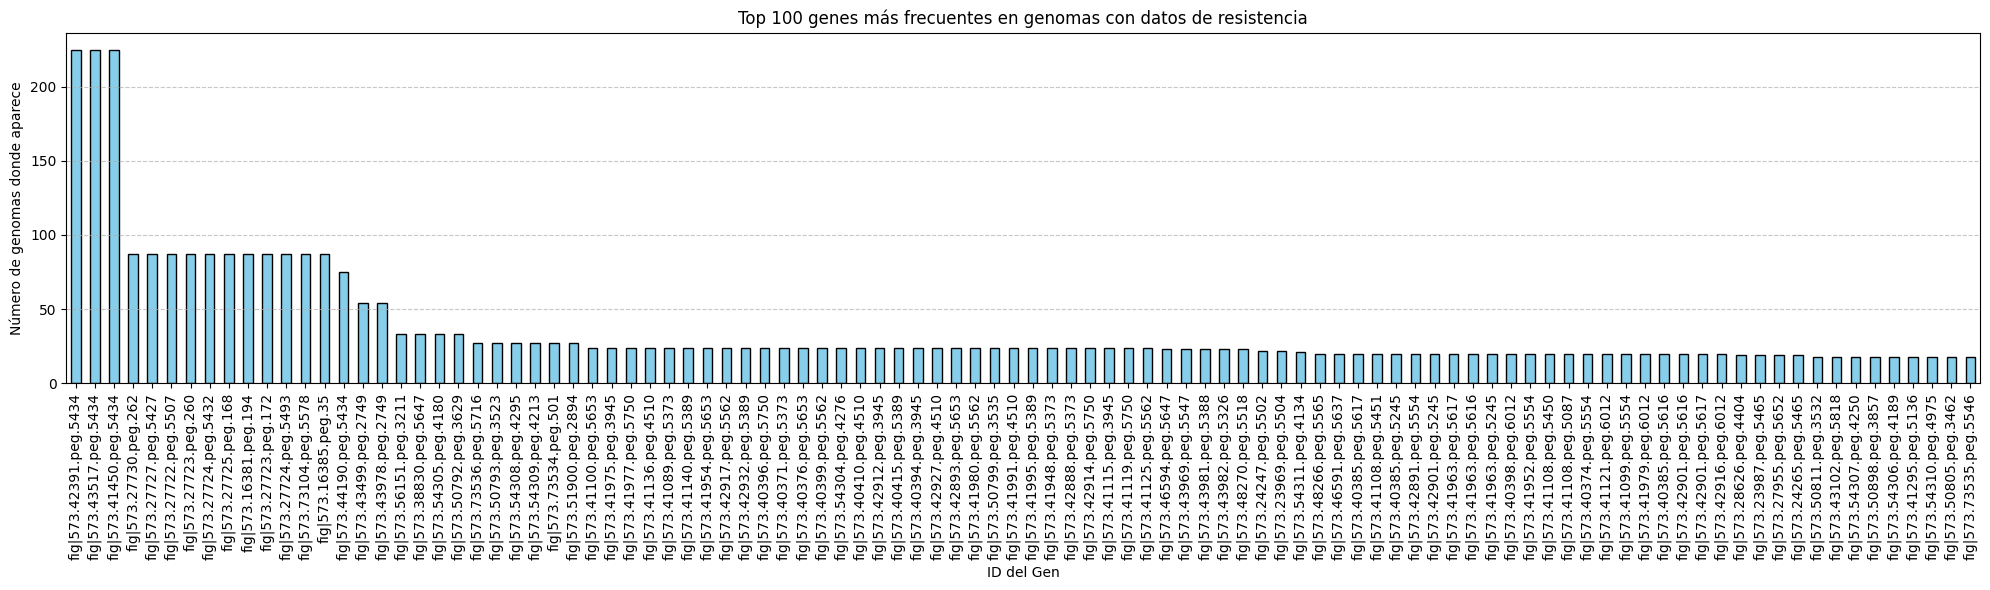

In [117]:
import matplotlib.pyplot as plt

# Frecuencia de los 100 genes más comunes
top_gene_counts = gene_counts.sort_values(ascending=False).head(100)

plt.figure(figsize=(20, 6))
top_gene_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Top 100 genes más frecuentes en genomas con datos de resistencia")
plt.xlabel("ID del Gen")
plt.ylabel("Número de genomas donde aparece")
plt.xticks(rotation=90)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [118]:
# Mostrar los nombres e incidencias
top_100_genes = top_gene_counts.reset_index()
top_100_genes.columns = ['Gene ID', 'Frecuencia']
print(top_100_genes)

                   Gene ID  Frecuencia
0   fig|573.42391.peg.5434         225
1   fig|573.43517.peg.5434         225
2   fig|573.41450.peg.5434         225
3    fig|573.27730.peg.262          87
4   fig|573.27727.peg.5427          87
..                     ...         ...
95  fig|573.54306.peg.4189          18
96  fig|573.41295.peg.5136          18
97  fig|573.54310.peg.4975          18
98  fig|573.50805.peg.3462          18
99  fig|573.73535.peg.5546          18

[100 rows x 2 columns]


In [119]:
!pip install xgboost


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [120]:
# División estratificada del dataset
X = df_scaled.drop(columns=['Resistance'])
y = df_scaled['Resistance']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Distribución de clases en y_train:")
print(y_train.value_counts())

Distribución de clases en y_train:
Resistance
0    10315
1     3069
Name: count, dtype: int64


In [121]:
#Modelo 1: Random Forest con validación cruzada y ajuste de hiperparámetros

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, recall_score # Importamos recall_score para visualizarlo
from imblearn.over_sampling import ADASYN
import pandas as pd

# Inicializar y aplicar ADASYN al conjunto de entrenamiento
adasyn = ADASYN(random_state=42)
X_resampled_adasyn, y_resampled_adasyn = adasyn.fit_resample(X_train, y_train)

print("\nDistribución de clases en y_resampled_adasyn (después de ADASYN):")
print(pd.Series(y_resampled_adasyn).value_counts())

# Definir la estrategia de validación cruzada estratificada
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid de hiperparámetros para Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# Validación cruzada + búsqueda de hiperparámetros
grid_rf_recall = GridSearchCV(
    RandomForestClassifier(random_state=42), 
    param_grid_rf,
    cv=skf,
    scoring='recall',
    n_jobs=-1
)
grid_rf_recall.fit(X_resampled_adasyn, y_resampled_adasyn)

# Evaluación final
print("\nBest Random Forest Params (optimizado por Recall con ADASYN):", grid_rf_recall.best_params_)
print("Test Classification Report (optimizado por Recall con ADASYN):\n", classification_report(y_test, grid_rf_recall.predict(X_test)))

print("\nResumen del Modelo: Random Forest con ADASYN (Optimizado por Recall)")
print("\nDistribución de clases en el conjunto de entrenamiento (antes de ADASYN):")
print(y_train.value_counts())
print("\nDistribución de clases en el conjunto de entrenamiento (después de ADASYN):")
print(pd.Series(y_resampled_adasyn).value_counts())
print("\nMejores hiperparámetros encontrados (optimizado por Recall con ADASYN):")
print(grid_rf_recall.best_params_)
print("\nRendimiento sobre el conjunto de prueba (20% del total):")
print(classification_report(y_test, grid_rf_recall.predict(X_test)))


Distribución de clases en y_resampled_adasyn (después de ADASYN):
Resistance
0    10315
1     8973
Name: count, dtype: int64

Best Random Forest Params (optimizado por Recall con ADASYN): {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Test Classification Report (optimizado por Recall con ADASYN):
               precision    recall  f1-score   support

           0       0.78      0.99      0.87      2579
           1       0.65      0.06      0.11       768

    accuracy                           0.78      3347
   macro avg       0.71      0.52      0.49      3347
weighted avg       0.75      0.78      0.70      3347


Resumen del Modelo: Random Forest con ADASYN (Optimizado por Recall)

Distribución de clases en el conjunto de entrenamiento (antes de ADASYN):
Resistance
0    10315
1     3069
Name: count, dtype: int64

Distribución de clases en el conjunto de entrenamiento (después de ADASYN):
Resistance
0    10315
1     8973
Name: count, dtype: int64

Mejores hiperp

In [122]:
# Modelo 2: SVM

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.preprocessing import StandardScaler # Importamos el escalador

# Escalar las características (importante para SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Distribución de clases en y_train:")
print(y_train.value_counts())

# Definir la estrategia de validación cruzada estratificada
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid de hiperparámetros para SVM
param_grid_svm_balanced = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.1, 1],
    'kernel': ['rbf']
}

# Validación cruzada + búsqueda de hiperparámetros para SVM con class_weight='balanced'
grid_svm_balanced = GridSearchCV(
    SVC(random_state=42, class_weight='balanced'), # Usamos class_weight
    param_grid_svm_balanced,
    cv=skf,
    scoring='f1', # Podemos empezar con F1
    n_jobs=-1
)
grid_svm_balanced.fit(X_train_scaled, y_train) # Entrenamos con los datos escalados

# Evaluación final del modelo SVM con class_weight='balanced'
print("\nBest SVM Params (con class_weight='balanced'):", grid_svm_balanced.best_params_)
print("Test Classification Report (SVM con class_weight='balanced'):\n", classification_report(y_test, grid_svm_balanced.predict(X_test_scaled)))

print("\nResumen del Modelo: SVM con class_weight='balanced'")
print("\nDistribución de clases en el conjunto de entrenamiento:")
print(y_train.value_counts())
print("\nMejores hiperparámetros encontrados (SVM con class_weight='balanced'):")
print(grid_svm_balanced.best_params_)
print("\nRendimiento sobre el conjunto de prueba (20% del total):")
print(classification_report(y_test, grid_svm_balanced.predict(X_test_scaled)))

Distribución de clases en y_train:
Resistance
0    10315
1     3069
Name: count, dtype: int64

Best SVM Params (con class_weight='balanced'): {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Test Classification Report (SVM con class_weight='balanced'):
               precision    recall  f1-score   support

           0       0.78      0.98      0.87      2579
           1       0.49      0.07      0.12       768

    accuracy                           0.77      3347
   macro avg       0.64      0.52      0.50      3347
weighted avg       0.71      0.77      0.70      3347


Resumen del Modelo: SVM con class_weight='balanced'

Distribución de clases en el conjunto de entrenamiento:
Resistance
0    10315
1     3069
Name: count, dtype: int64

Mejores hiperparámetros encontrados (SVM con class_weight='balanced'):
{'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}

Rendimiento sobre el conjunto de prueba (20% del total):
              precision    recall  f1-score   support

           0       0.7

In [ ]:
#Modelo 3: XGBoost
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import pandas as pd


# Escalar las características (ya hecho)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Distribución de clases en y_train:")
print(y_train.value_counts())

# Definir la estrategia de validación cruzada estratificada (ya definido)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid de hiperparámetros para XGBoost (sin scale_pos_weight en la búsqueda)
param_grid_xgb_recall = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

# Validación cruzada + búsqueda de hiperparámetros para XGBoost (optimización por recall)
grid_xgb_recall = GridSearchCV(
    XGBClassifier(objective='binary:logistic', random_state=42),
    param_grid_xgb_recall,
    cv=skf,
    scoring='recall', # Cambiamos la métrica a 'recall'
    n_jobs=-1
)
grid_xgb_recall.fit(X_train_scaled, y_train)

# Evaluación final del modelo XGBoost
print("\nBest XGBoost Params (optimizado por Recall):", grid_xgb_recall.best_params_)
print("Test Classification Report (XGBoost optimizado por Recall):\n", classification_report(y_test, grid_xgb_recall.predict(X_test_scaled)))

print("\nResumen del Modelo: XGBoost (optimizado por Recall)")
print("\nDistribución de clases en el conjunto de entrenamiento:")
print(y_train.value_counts())
print("\nMejores hiperparámetros encontrados (XGBoost optimizado por Recall):")
print(grid_xgb_recall.best_params_)
print("\nRendimiento sobre el conjunto de prueba (20% del total):")
print(classification_report(y_test, grid_xgb_recall.predict(X_test_scaled)))

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener el mejor modelo de GridSearchCV
best_xgb_model = grid_xgb_no_weight.best_estimator_

# Obtener la importancia de las características
feature_importances = best_xgb_model.feature_importances_

# Obtener los nombres de las características (asumiendo que X_train_scaled provino de un DataFrame con columnas)
feature_names = X.columns

# Crear un DataFrame para visualizar la importancia de las características
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Visualizar las N características más importantes (ajusta N según sea necesario)
n_top_features = 20
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df.head(n_top_features))
plt.title(f'Top {n_top_features} Feature Importances (XGBoost)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Imprimir la lista de las características más importantes
print("\nTop Feature Importances (XGBoost):")
print(importances_df.head(n_top_features))

In [ ]:
import pandas as pd
from Bio import SeqIO

# Lista de los genes más importantes
top_features_raw = [
    "fig|573.38830.peg.5647",
    "fig|573.41100.peg.5653",
    "fig|573.43978.peg.2749",
    "fig|573.23987.peg.5465",
    "fig|573.44190.peg.5434",
    "fig|573.54304.peg.4276",
    "fig|573.54310.peg.4975",
    "fig|573.28626.peg.4404",
    "fig|573.43499.peg.2749",
    "fig|573.43102.peg.5818",
    "fig|573.24247.peg.5502",
    "fig|573.40398.peg.6012",
    "fig|573.40385.peg.5617",
    "fig|573.41140.peg.5389",
    "fig|573.48266.peg.5565",
    "fig|573.41089.peg.5373",
    "fig|573.41136.peg.4510",
    "fig|573.41295.peg.5136",
    "fig|573.42391.peg.5434",
    "fig|573.50799.peg.3535"
]

# Limpiar la lista de características
top_features = [feature.strip() for feature in top_features_raw]
top_features_set = set(top_features)

genes_fasta = 'C:/Users/judit/OneDrive/Escritorio/MÁSTER/TFM/data/BVBRC_genome_feature.fasta'

gene_functions = []

for record in SeqIO.parse(genes_fasta, "fasta"):
    for gene_id in top_features_set:
        if gene_id in record.description:
            parts = record.description.split('|')
            function_description = " ".join(parts[3:]) if len(parts) > 3 else "Función no disponible"
            gene_functions.append({'Gene ID': gene_id, 'Función': function_description})
            break

gene_functions_df = pd.DataFrame(gene_functions)
print("\nDataFrame de las funciones de los genes importantes:")
print(gene_functions_df)

In [ ]:
from Bio import SeqIO
import pandas as pd

# Tu lista top_features
top_features = [
    "fig|573.41136.peg.4510",
    "fig|573.42391.peg.5434",
    "fig|573.40398.peg.6012",
    "fig|573.43499.peg.2749",
    "fig|573.40385.peg.5617",
    "fig|573.43978.peg.2749",
    "fig|573.38830.peg.5647",
    "fig|573.44190.peg.5434",
    "fig|573.41295.peg.5136",
    "fig|573.28626.peg.4404",
    "fig|573.54304.peg.4276",
    "fig|573.48266.peg.5565",
    "fig|573.50799.peg.3535",
    "fig|573.24247.peg.5502",
    "fig|573.41100.peg.5653",
    "fig|573.41089.peg.5373",
    "fig|573.41140.peg.5389",
    "fig|573.23987.peg.5465",
    "fig|573.43102.peg.5818",
    "fig|573.54310.peg.4975"
]
top_features_set = set(top_features)

genes_fasta = 'C:/Users/judit/OneDrive/Escritorio/MÁSTER/TFM/data/BVBRC_genome_feature.fasta'

fasta_ids = []
for record in SeqIO.parse(genes_fasta, "fasta"):
    fasta_ids.append(record.id.strip())

print("Primeros 20 IDs del archivo FASTA (record.id):")
print(fasta_ids[:20])
print("\nPrimeros 20 IDs de tu lista top_features:")
print(top_features[:20])

found_matches = set(top_features) & set(fasta_ids)
not_found_in_fasta = set(top_features) - set(fasta_ids)
not_found_in_top = set(fasta_ids) - set(top_features)

print(f"\nNúmero de coincidencias encontradas: {len(found_matches)}")
print(f"Genes importantes NO encontrados en los IDs del FASTA: {not_found_in_fasta}")
print(f"IDs del FASTA NO encontrados en los genes importantes: {not_found_in_top[:20]}") # Mostrar solo los primeros 20